# Finetuning a Pretrained Model

The pretrained model usually captures general chemistry rules and as such is best trained on a diverse set of molecules (see [pretraining](./pretraining.ipynb)). However, in drug discovery we usually want to bias such a model to a more focused area of chemical space, which is what happens during finetuning. In this tutorial, we will use the finetuning data sets created [previously](./datasets.ipynb) to bias an already existing model. The pretrained models we will use are already placed in the `jupyter/models/pretrained` folder.

## Finetuning a Graph-Based Model

The particular model for this tutorial is pretrained on the ChEMBL database (version 27) with its states saved at `jupyter/models/pretrained/graph/chembl27/chembl27_graph.pkg`. However, before we can load its states the model needs to be initialized so we will need the vocabulary of the model first, which is saved alongside it:

In [15]:
GPUS = [0]
EPOCHS = 3

In [16]:
from drugex.data.corpus.vocabulary import VocGraph

vocabulary = VocGraph.fromFile('jupyter/models/pretrained/graph/chembl27/chembl27_graph_voc.txt')
vocabulary

Now we can initialize the model and load the saved states:

In [17]:
from drugex.training.models.transform import GraphModel

pretrained = GraphModel(voc_trg=vocabulary, use_gpus=GPUS) # attach this model to only the first GPU, but more can be specified
pretrained.loadStatesFromFile('jupyter/models/pretrained/graph/chembl27/chembl27_graph.pkg')

Next, we need to load our finetuning data we created in the [previous tutorial](datasets.ipynb):

In [18]:
from drugex.data.datasets import GraphFragDataSet

finetuning_data_train = GraphFragDataSet("jupyter/data/sets/graph/ligand_train.tsv")
finetuning_data_test = GraphFragDataSet("jupyter/data/sets/graph/ligand_test.tsv")

We can verify the data has been loaded by converting it to pandas `DataFrame`:

In [19]:
finetuning_data_train.getData()

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [20]:
finetuning_data_test.getData()

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

Finally, we can proceed to finetuning the model (note that we need to transform the `DataSet` to `DataLoader` and specify the batch size):

In [25]:
from drugex.training.monitors import FileMonitor
import pandas as pd
import numpy as np

monitor = FileMonitor('jupyter/models/finetuned/graph/chembl_ligand', verbose=True)
pretrained.fit(
    finetuning_data_train.asDataLoader(128), # create the data loader and specify the batch size
    finetuning_data_test.asDataLoader(128), 
    epochs=3, # only 3 epochs to make things faster
    monitor=monitor
)

print("Finetuning done.")

Fitting model: 100%|██████████| 3/3 [00:41<00:00, 13.88s/it]

Finetuning done.


If you want to follow the training progress, you can periodically check the `data/models/finetuned/chembl_ligand_fit.log` file that is created by the `FileMonitor` along with other files and also the states of the best performing model. The `FileMonitor` is useful when you want to analyze the data generating during training later. You can load these files easily as pandas data frames:

In [26]:
# training summary with mean training loss and validation loss
df_info = pd.read_csv('jupyter/models/finetuned/graph/chembl_ligand_fit.tsv', sep='\t')
df_info

,epoch,loss_train,loss_valid,valid_ratio,unique_ratio,desire_ratio,mean_train_loss
0,1,NaN,2.702629,1.0,NaN,0.990431,1.426907
1,2,NaN,2.415267,1.0,NaN,0.995215,1.258194
2,3,NaN,2.170367,1.0,NaN,1.000000,1.124571


In [24]:
# smiles generated at each epoch from the validation set and the input fragment(s) used to generate each
df_smiles = pd.read_csv('jupyter/models/finetuned/graph/chembl_ligand_smiles.tsv', sep='\t')
df_smiles.head()

,SMILES,Valid,Desire,Frags,Epoch
0,Nc1nc(-c2cc(NC(=O)Cc3ccc(F)cc3)c(F)cc2F)nc2nc(...,1.0,1.0,C1CCNC1.Fc1cccc(F)c1.Nc1ncnc2ncnn12,1
1,C#CCNC(=O)C(CCC(=O)O)NC(=O)Cc1cnc(-c2cccc(Cl)c...,1.0,1.0,Clc1ccccc1,1
2,NCCC1CCCSC1=O,1.0,1.0,O=CS,1
3,O=c1c2cc(I)cc(CO)c2c(=O)n2c3ccc(-c4ccc(-c5cccc...,1.0,1.0,c1ccnnc1,1
4,CC(C)(C)C(Cc1ccc(Cl)cc1)N1CCN(c2ccccc2C#N)CC1,1.0,1.0,C1CNCCN1.CCC.Clc1ccccc1,1


With these data, we can easily generate a model performance plot for each epoch:

<AxesSubplot:>

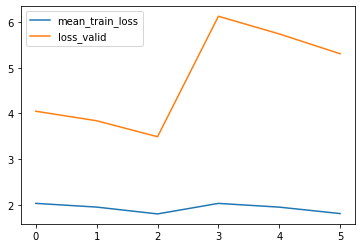

In [10]:
df_info[['mean_train_loss', 'loss_valid']].plot.line()

The monitor also enables us to get the best model's states for initialization of a new instance for generation or another round of finetuning:

In [11]:
ft_model = monitor.getModel()
ft_model['emb_word.weight']

tensor([[-0.0205, -0.0666, -0.0142,  ...,  0.0925,  0.0784,  0.0773],
        [ 0.0902,  0.0458, -0.0819,  ..., -0.0799,  0.0197,  0.0698],
        [ 0.0079, -0.0163,  0.0373,  ..., -0.0541,  0.0064, -0.0043],
        ...,
        [ 0.0149, -0.0912,  0.1480,  ...,  0.0100,  0.0516, -0.0902],
        [ 0.1013,  0.1127, -0.1173,  ...,  0.2811, -0.1796, -0.0870],
        [ 0.1036, -0.0346,  0.0283,  ..., -0.0144, -0.0385, -0.1008]],
       device='cuda:0')

In [12]:
other_model = GraphModel(voc_trg=vocabulary)
other_model.load_state_dict(ft_model)

<All keys matched successfully>

For consistency, we will also save the used vocabulary with the model so that we can always initialize it exactly the way we did during finetuning:

In [27]:
vocabulary.toFile('jupyter/models/finetuned/graph/ligand_finetuned.vocab')